**Import Libraries and Load Data**

In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
  

In [2]:
dataset_directory = '/kaggle/input/road-risk-classification/'

# List all files and directories in the dataset directory
for dirpath, dirnames, filenames in os.walk(dataset_directory):
    print(f"Found directory: {dirpath}")
    for filename in filenames:
        print(f"File: {filename}")

Found directory: /kaggle/input/road-risk-classification/
File: sol.csv
Found directory: /kaggle/input/road-risk-classification/sol
File: 00121_5b79547633c24e119ff2a850f607cf19.jpg
File: 00028_a3bb7eb11edc4f19a9bae766f15b3584.jpg
File: 00032_04ee39ead31c4d4ca90cace49348b36e.jpg
File: 00094_84cdd77ec8a347a7b88aae68ea58520b.jpg
File: 00024_8dae663e387043e38361d16ba268dc59.jpg
File: 00061_c6130202a4fe42a4a21fb0f956ee0d0d.jpg
File: 00016_51b10f282ce74966822582b03e78334f.jpg
File: 00002_5e91a487e88f40a5a0d51273b1f6e51e.jpg
File: 00016_005d2bb11a0d42c28f9a194612c73a9c.jpg
File: 00049_42829334e2ae48fba5198f06e0732433.jpg
File: 00111_eb9caa38169b4cd2a4dfc7003faf9fba.jpg
File: 00094_317ed852bfb74d618da61a23612f80f6.jpg
File: 00078_99244cf046cb4c599b7be5b65dfd346c.jpg
File: 00015_8bef8372997e41c4897d1be07375bdc1.jpg
File: 00093_49f74674009c44ec90024c1725d007d3.jpg
File: 00009_c0bb997def244158b59d69e7797ed4a9.jpg
File: 00040_f702bff7b15643f69d5d0d6d1c0ac4ee.jpg
File: 00058_c155cf56984e49fab26ad132

In [3]:
import os
from collections import Counter

# Set the paths to the sol and train directories
directories = ['/kaggle/input/road-risk-classification/sol', '/kaggle/input/road-risk-classification/train']

# Initialize a dictionary to store file type counts for each directory
file_types = {}

# Loop through each directory to list files and count their types
for directory in directories:
    files = os.listdir(directory)
    file_type_count = Counter(os.path.splitext(file)[1] for file in files)
    file_types[directory] = file_type_count

# Print the file types and counts for each directory
for directory, counts in file_types.items():
    print(f"Directory: {directory}")
    for file_type, count in counts.items():
        print(f"File Type: {file_type}, Count: {count}")


Directory: /kaggle/input/road-risk-classification/sol
File Type: .jpg, Count: 19457
Directory: /kaggle/input/road-risk-classification/train
File Type: , Count: 2


**Load and Check the sol.csv**

In [4]:
# Load the CSV file
sol_data = pd.read_csv('/kaggle/input/road-risk-classification/sol.csv')

# Display the first few rows of the dataframe
print(sol_data.head())


   file_name  risk
0  road_0179     0
1  road_0180     0
2  road_0181     0
3  road_0182     0
4  road_0183     0


** Identify Files in the Train Directory**

In [6]:
train_directory = '/kaggle/input/road-risk-classification/train/'
train_files = os.listdir(train_directory)

# Print out the names of the files in the train directory
for file in train_files:
    print(f"File Name: {file}, File Type: {os.path.splitext(file)[1]}")

    

File Name: 0, File Type: 
File Name: 1, File Type: 


In [7]:
train_directory = '/kaggle/input/road-risk-classification/train/'

# Loop through each potential subdirectory in the train directory
for sub_dir in os.listdir(train_directory):
    sub_dir_path = os.path.join(train_directory, sub_dir)
    if os.path.isdir(sub_dir_path):  # Check if it is a directory
        print(f"Contents of {sub_dir}:")
        sub_files = os.listdir(sub_dir_path)
        # Print file names and count JPEGs
        jpeg_count = sum(1 for file in sub_files if file.endswith('.jpg'))
        print(f"JPEG Files Count: {jpeg_count}")
    else:
        print(f"Found file: {sub_dir}, which is not a directory.")


Contents of 0:
JPEG Files Count: 20194
Contents of 1:
JPEG Files Count: 7855


**Load Images and Prepare Dataset**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your training data
train_data_dir = '/kaggle/input/road-risk-classification/train/'

# Create an ImageDataGenerator for training data with rescaling and a validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Setting a 20% split for validation
)

# Setup training data generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='training'  # Specify this is training data
)

# Setup validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation'  # Specify this is validation data
)


Found 22440 images belonging to 2 classes.
Found 5609 images belonging to 2 classes.


**Model Building**

In [12]:
# Define the CNN architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50  
)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - accuracy: 0.6582 - loss: 0.7599 - val_accuracy: 0.7370 - val_loss: 0.5738
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.7170 - loss: 0.5971 - val_accuracy: 0.7270 - val_loss: 0.5849
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.7255 - loss: 0.5683 - val_accuracy: 0.7240 - val_loss: 0.5889
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - accuracy: 0.7023 - loss: 0.5816 - val_accuracy: 0.7190 - val_loss: 0.6178
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.7127 - loss: 0.5869 - val_accuracy: 0.7390 - val_loss: 0.5699
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.7105 - loss: 0.5683 - val_accuracy: 0.7143 - val_loss: 0.5777
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.7051 - loss: 0.5795 - val_accuracy: 0.7310 - val_loss: 0.5623
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.7473 - loss: 0

Final Training Accuracy: 76.70%
Final Validation Accuracy: 69.00%
Final Training Loss: 0.4819
Final Validation Loss: 0.6004


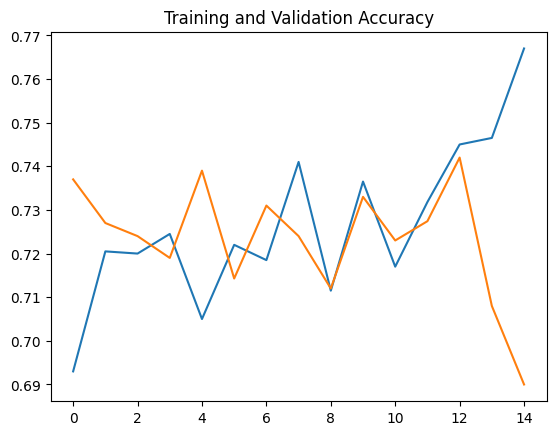

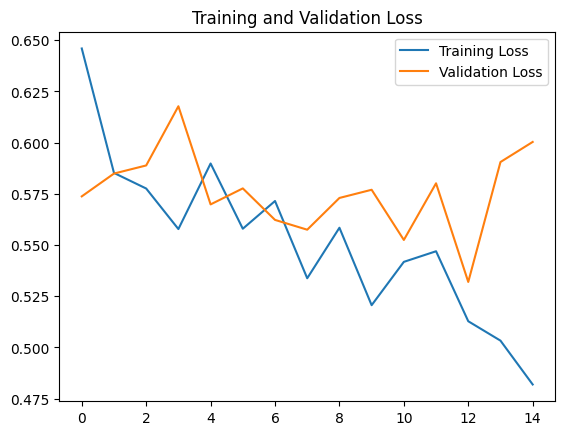

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  

# Display final accuracy and loss
print(f"Final Training Accuracy: {acc[-1]*100:.2f}%")
print(f"Final Validation Accuracy: {val_acc[-1]*100:.2f}%")
print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


**Data Augmentation**

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,  
    width_shift_range=0.25,  
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.3,  
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]  
)


In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=100, 
    epochs=20,  
    validation_data=validation_generator,
    validation_steps=50 
)

# Training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Final epoch accuracy and loss
final_train_accuracy = acc[-1] * 100
final_val_accuracy = val_acc[-1] * 100
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]

# Printing the results
print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 254ms/step - accuracy: 0.7503 - loss: 0.5064 - val_accuracy: 0.7270 - val_loss: 0.5552
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - accuracy: 0.7646 - loss: 0.4694 - val_accuracy: 0.7530 - val_loss: 0.5195
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.7633 - loss: 0.4864 - val_accuracy: 0.7130 - val_loss: 0.5722
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.7688 - loss: 0.4803 - val_accuracy: 0.7230 - val_loss: 0.5190
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.7547 - loss: 0.5080 - val_accuracy: 0.7280 - val_loss: 0.5636
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7515 - loss: 0.4794 - val_accuracy: 0.7011 - val_loss: 0.5856
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.7579 - loss: 0.4748 - val_accuracy: 0.7140 - val_loss: 0.5491
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.7761 - loss: 0

**Pre-trained Model VGG16**

In [19]:
# Load the VGG16 network
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create a new model on top
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    metrics=['accuracy']
)


In [20]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=20, 
    validation_data=validation_generator,
    validation_steps=50  
)

# After training, evaluate the model's performance
final_train_accuracy = history.history['accuracy'][-1] * 100
final_val_accuracy = history.history['val_accuracy'][-1] * 100
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final metrics
print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 252ms/step - accuracy: 0.6553 - loss: 0.6715 - val_accuracy: 0.7170 - val_loss: 0.5691
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - accuracy: 0.7162 - loss: 0.5729 - val_accuracy: 0.7200 - val_loss: 0.5616
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.7206 - loss: 0.5551 - val_accuracy: 0.7450 - val_loss: 0.5311
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.7291 - loss: 0.5191 - val_accuracy: 0.7310 - val_loss: 0.5248
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 0.7480 - loss: 0.5121 - val_accuracy: 0.7420 - val_loss: 0.5035
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.7627 - loss: 0.4891 - val_accuracy: 0.7504 - val_loss: 0.5013
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - accuracy: 0.7810 - loss: 0.4562 - val_accuracy: 0.7690 - val_loss: 0.4586
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.7964 - loss: 0

**K-Fold Cross-Validation with Image Data**

In [24]:
data_dir = '/kaggle/input/road-risk-classification/train'  # Adjusted to a hypothetical 'train' folder

# List only directories (assuming each directory corresponds to a class)
class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Create a list of all file paths and their labels
file_paths = []
labels = []
for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    class_files = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.endswith('.jpg')]  # Ensuring only image files are added
    file_paths.extend(class_files)
    labels.extend([class_index] * len(class_files))

file_paths = np.array(file_paths)
labels = np.array(labels)


In [26]:
# Convert labels to strings
train_labels_str = [str(label) for label in train_labels]
val_labels_str = [str(label) for label in val_labels]

# Creating dataframes for train and validation
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels_str})
val_df = pd.DataFrame({'filename': val_files, 'class': val_labels_str})

# Create generators
train_data = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'  # This now matches the string labels
)

val_data = val_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 22439 validated image filenames belonging to 2 classes.
Found 5610 validated image filenames belonging to 2 classes.


In [27]:
def create_model():
 model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

results = []

for train_index, val_index in kf.split(file_paths):
    train_files, val_files = file_paths[train_index], file_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    train_df = pd.DataFrame({'filename': train_files, 'class': [str(label) for label in train_labels]})
    val_df = pd.DataFrame({'filename': val_files, 'class': [str(label) for label in val_labels]})

    train_data = train_gen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary'
    )

    val_data = val_gen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary'
    )

    model = create_model()
    history = model.fit(train_data, epochs=10, validation_data=val_data)

    results.append({
        'train_accuracy': max(history.history['accuracy']),
        'val_accuracy': max(history.history['val_accuracy']),
        'train_loss': min(history.history['loss']),
        'val_loss': min(history.history['val_loss'])
    })

# Calculate average of the recorded metrics
average_results = {
    'train_accuracy': np.mean([x['train_accuracy'] for x in results]),
    'val_accuracy': np.mean([x['val_accuracy'] for x in results]),
    'train_loss': np.mean([x['train_loss'] for x in results]),
    'val_loss': np.mean([x['val_loss'] for x in results])
}
print("Average Results across all folds:", average_results)


Found 22439 validated image filenames belonging to 2 classes.
Found 5610 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 99s 83ms/step - accuracy: 0.8373 - loss: 0.3590 - val_accuracy: 0.9936 - val_loss: 0.0195
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9948 - loss: 0.0152 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.9974 - loss: 0.0107 - val_accuracy: 0.9989 - val_loss: 0.0035
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 89s 79ms/step - accuracy: 0.9980 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 9.2834e-05
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.9991 - loss: 0.0043 - val_accuracy: 0.9973 - val_loss: 0.0065
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9998 - val_loss: 0.0010
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9975 - loss: 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 97s 81ms/step - accuracy: 0.8679 - loss: 0.3046 - val_accuracy: 0.9977 - val_loss: 0.0071
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 86s 76ms/step - accuracy: 0.9938 - loss: 0.0195 - val_accuracy: 0.9989 - val_loss: 0.0059
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.9977 - loss: 0.0086 - val_accuracy: 0.9980 - val_loss: 0.0054
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.9970 - loss: 0.0107 - val_accuracy: 0.9996 - val_loss: 0.0012
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 86s 76ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9968 - val_loss: 0.0110
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.9986 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 2.5454e-05
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 89s 79ms/step - accuracy: 1.0000 - loss: 2.3194e-04 - val_accuracy: 0.9964 - val_loss: 0.0137
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9931 - lo

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 103s 86ms/step - accuracy: 0.8692 - loss: 0.2943 - val_accuracy: 0.9959 - val_loss: 0.0145
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 89s 79ms/step - accuracy: 0.9953 - loss: 0.0139 - val_accuracy: 0.9980 - val_loss: 0.0079
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 89s 79ms/step - accuracy: 0.9968 - loss: 0.0120 - val_accuracy: 0.9991 - val_loss: 0.0063
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9973 - loss: 0.0085 - val_accuracy: 0.9948 - val_loss: 0.0153
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 0.9998 - val_loss: 7.9590e-04
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.9991 - loss: 0.0044 - val_accuracy: 0.9986 - val_loss: 0.0053
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9975 - loss: 0.0085 - val_accuracy: 0.9998 - val_loss: 7.7350e-04
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 90s 80ms/step - accuracy: 0.9983 - l

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 98s 82ms/step - accuracy: 0.8646 - loss: 0.3185 - val_accuracy: 0.9932 - val_loss: 0.0247
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 91s 81ms/step - accuracy: 0.9943 - loss: 0.0187 - val_accuracy: 0.9986 - val_loss: 0.0042
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 91s 81ms/step - accuracy: 0.9958 - loss: 0.0145 - val_accuracy: 0.9995 - val_loss: 0.0012
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9993 - val_loss: 0.0018
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9971 - loss: 0.0115 - val_accuracy: 0.9993 - val_loss: 0.0078
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9983 - loss: 0.0090 - val_accuracy: 0.9982 - val_loss: 0.0111
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 86s 76ms/step - accuracy: 0.9979 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 6.0376e-05
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 90s 80ms/step - accuracy: 0.9982 - loss: 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 96s 80ms/step - accuracy: 0.8389 - loss: 0.3568 - val_accuracy: 0.9984 - val_loss: 0.0072
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.9949 - loss: 0.0174 - val_accuracy: 0.9982 - val_loss: 0.0039
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.9980 - loss: 0.0082 - val_accuracy: 0.9995 - val_loss: 0.0018
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 0.9996 - val_loss: 0.0024
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9979 - loss: 0.0064 - val_accuracy: 0.9993 - val_loss: 0.0018
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 86s 76ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 1.8261e-04
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 89s 79ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9995 - val_loss: 0.0018
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.9983 - loss: 

**Retrain on entire data**

In [28]:
all_data_df = pd.DataFrame({
    'filename': file_paths,
    'class': [str(label) for label in labels]
})

# Create an ImageDataGenerator for the entire dataset
data_gen = ImageDataGenerator(rescale=1./255)

# Create a generator for the entire dataset
full_data_generator = data_gen.flow_from_dataframe(
    dataframe=all_data_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=True
)


Found 28049 validated image filenames belonging to 2 classes.


In [29]:
def create_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Determine the number of steps per epoch
steps_per_epoch = len(all_data_df) // 20  

history = model.fit(
    full_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10  
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1402/1402 ━━━━━━━━━━━━━━━━━━━━ 97s 65ms/step - accuracy: 0.8630 - loss: 0.3078
Epoch 2/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 1.0000 - loss: 0.0017  
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1402/1402 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.9966 - loss: 0.0105
Epoch 4/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 1.0000 - loss: 0.0034  
Epoch 5/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 88s 63ms/step - accuracy: 0.9970 - loss: 0.0090
Epoch 6/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 1.0000 - loss: 8.0155e-06  
Epoch 7/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 89s 63ms/step - accuracy: 0.9987 - loss: 0.0041
Epoch 8/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 1.0000 - loss: 1.9386e-04  
Epoch 9/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 88s 62ms/step - accuracy: 0.9973 - loss: 0.0096
Epoch 10/10
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 1.0000 - loss: 7.1095e-05  


In [31]:
final_train_accuracy = history.history['accuracy'][-1] * 100  
final_train_loss = history.history['loss'][-1]  

print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")


Final Training Accuracy: 100.00%
Final Training Loss: 0.0001


In [32]:
model.save('/kaggle/working/Traffic_accident_prediction.h5')
 
